In [14]:
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV for image processing
import random
%matplotlib widget




In [15]:
# Define the path to the checkpoint and the model type
checkpoint_path = "checkpoints/sam_checkpoint.pth"  # Path to the downloaded checkpoint
model_type = "default"  # Replace with the actual model type, e.g., "default"

# Load the model
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
predictor = SamPredictor(sam)





In [16]:
# Load your image
image_path = "images/stickynote.jpg"  # Path to your image file
image = Image.open(image_path)
image_np = np.array(image)

# Set the image in the predictor
predictor.set_image(image_np)





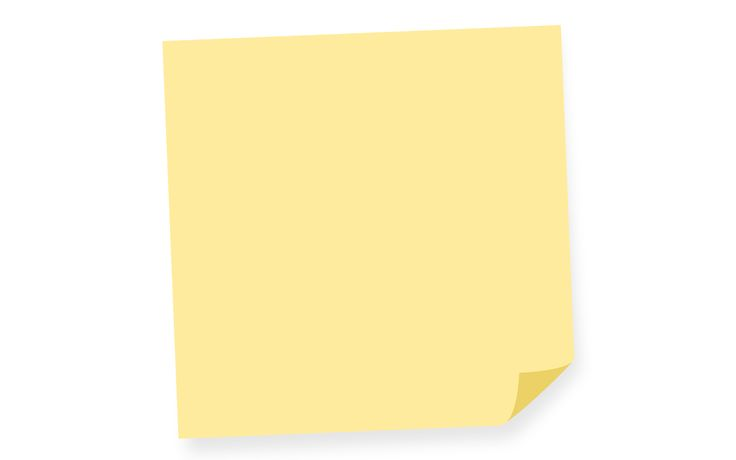

In [17]:
image

In [30]:
# Convert the image to the HSV color space
hsv_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

# Adjust the color range for the yellow object to exclude shadows
lower_yellow = np.array([25, 150, 150])  # Narrower range to exclude shadows
upper_yellow = np.array([35, 255, 255])

# Create a mask for the yellow object
mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

# Find contours of the object
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get a point near the center of the largest contour assuming it's the object
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Select a point near the center of the bounding box
    cX = x + w // 2
    cY = y + h // 2
    foreground_point = (cX, cY)
else:
    foreground_point = (0, 0)  # Default to (0, 0) if no contour is found

# Combine points and labels
input_points = np.array([foreground_point])
input_labels = np.array([1])  # 1 for foreground

print("Selected point:", input_points)




Selected point: [[539 390]]


In [31]:
# Generate masks
masks, _, _ = predictor.predict(point_coords=input_points, point_labels=input_labels)


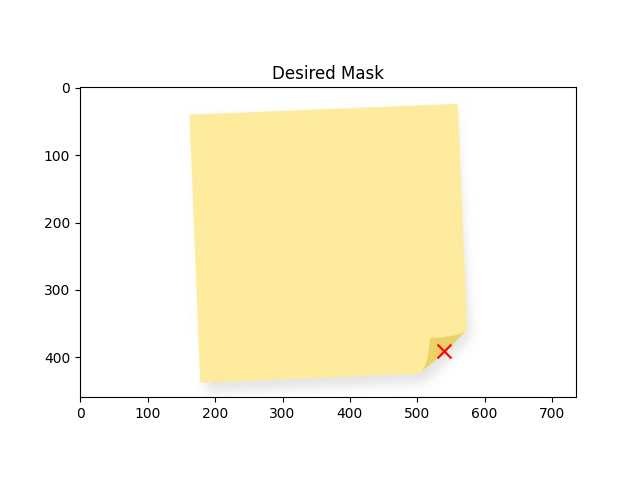

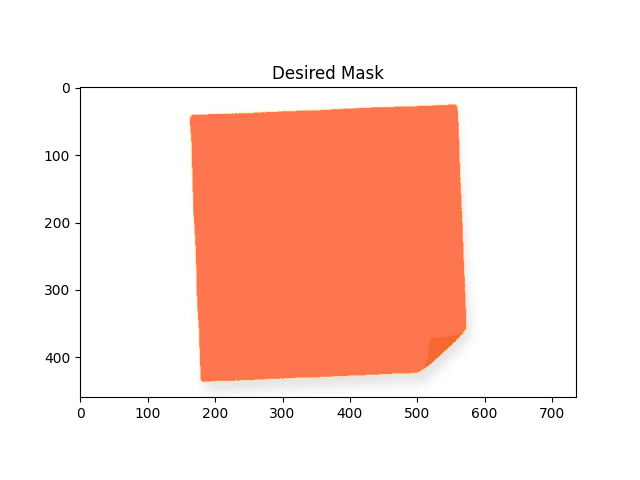

In [34]:
# Define a function to overlay a colored mask on the image
def overlay_mask(image, mask, color, alpha=0.5):
    """Overlay a colored mask on the image."""
    colored_image = image.copy()
    for i in range(3):  # Apply color to each channel
        colored_image[:, :, i] = np.where(mask == 1, color[i], image[:, :, i])
    return cv2.addWeighted(colored_image, alpha, image, 1 - alpha, 0)

# Choose a color for the mask (e.g., red)
mask_color = [255, 0, 0]  # Red color

# Display the original image with the selected point
plt.imshow(image_np)
plt.scatter(input_points[:, 0], input_points[:, 1], c='red', s=100, marker='x')  # Highlight the selected point
plt.show()

# Assuming the desired mask is the second one (mask 2)
desired_mask_index = 2

if desired_mask_index < len(masks):
    mask_np = masks[desired_mask_index].astype(np.uint8)
    
    # Overlay the desired mask and display the result
    colored_mask_image = overlay_mask(image_np, mask_np, mask_color)
    plt.figure()
    plt.title(f"Desired Mask")
    plt.imshow(colored_mask_image)
    plt.show()

    # Save the desired mask
    mask_image = Image.fromarray(mask_np * 255)
    mask_image.save(f"desired_mask_{desired_mask_index}.png")
else:
    print(f"No mask found at index {desired_mask_index}.")
